## Intro to PyTorch Tensors


(The next few lines are stolen from here: https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial2/Introduction_to_PyTorch.ipynb#scrollTo=s7cMyvT6lg2_)

Tensors are the PyTorch equivalent to Numpy arrays, with the addition to also have support for GPU acceleration (more on that later). The name "tensor" is a generalization of concepts you already know. For instance, a vector is a 1-D tensor, and a matrix a 2-D tensor. When working with neural networks, we will use tensors of various shapes and number of dimensions.

Most common functions you know from numpy can be used on tensors as well. Actually, since numpy arrays are so similar to tensors, we can convert most tensors to numpy arrays (and back) but we don't need it too often.



In [3]:
import torch
import numpy as np
x = torch.Tensor(2, 3, 4)
print(x)

tensor([[[4.3526e+03, 3.0667e-41, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]],

        [[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]]])


In [4]:
# Create a tensor from a (nested) list
x = torch.Tensor([[1, 2], [3, 4]])
print(x)

tensor([[1., 2.],
        [3., 4.]])


In [5]:
# Create a tensor with random values between 0 and 1 with the shape [2, 3, 4]
x = torch.rand(2, 3, 4)
print(x)

tensor([[[0.7711, 0.2855, 0.6440, 0.2049],
         [0.6453, 0.8711, 0.9064, 0.2619],
         [0.0031, 0.4403, 0.3517, 0.0499]],

        [[0.8255, 0.5054, 0.4248, 0.1429],
         [0.3897, 0.4608, 0.8065, 0.5663],
         [0.1808, 0.4620, 0.9881, 0.5954]]])


In [6]:
shape = x.shape
print("Shape:", x.shape)

size = x.size()
print("Size:", size)

dim1, dim2, dim3 = x.size()
print("Size:", dim1, dim2, dim3)

Shape: torch.Size([2, 3, 4])
Size: torch.Size([2, 3, 4])
Size: 2 3 4


In [7]:
np_arr = np.array([[1, 2], [3, 4]])
tensor = torch.from_numpy(np_arr)

print("Numpy array:", np_arr)
print("PyTorch tensor:", tensor)

Numpy array: [[1 2]
 [3 4]]
PyTorch tensor: tensor([[1, 2],
        [3, 4]])


In [8]:
x1 = torch.rand(2, 3)
x2 = torch.rand(2, 3)
y = x1 + x2

print("X1", x1)
print("X2", x2)
print("Y", y)

X1 tensor([[0.7722, 0.0716, 0.2671],
        [0.7539, 0.8937, 0.7247]])
X2 tensor([[0.2537, 0.0175, 0.7692],
        [0.4459, 0.9184, 0.4322]])
Y tensor([[1.0259, 0.0891, 1.0363],
        [1.1997, 1.8121, 1.1569]])


In [9]:
x1

tensor([[0.7722, 0.0716, 0.2671],
        [0.7539, 0.8937, 0.7247]])

In [10]:
x1[0]

tensor([0.7722, 0.0716, 0.2671])

In [11]:
x1[1]

tensor([0.7539, 0.8937, 0.7247])

In [12]:
x1[:, 0]

tensor([0.7722, 0.7539])

In [13]:
x1

tensor([[0.7722, 0.0716, 0.2671],
        [0.7539, 0.8937, 0.7247]])

In [14]:
x1[None, :,]

tensor([[[0.7722, 0.0716, 0.2671],
         [0.7539, 0.8937, 0.7247]]])

In [15]:
print(x1.shape)
print(x1[None, :, :].shape)
print(x1[None, ...].shape)

torch.Size([2, 3])
torch.Size([1, 2, 3])
torch.Size([1, 2, 3])


In [16]:
print(x1[..., 1].shape)

torch.Size([2])


In [17]:
print(x1[..., 1][None, ...].T)

tensor([[0.0716],
        [0.8937]])


In [18]:
indexes = torch.LongTensor([0])
print(x1[indexes])
indexes = torch.LongTensor([0, 1, 0, 0, 0])
print(x1[indexes])

tensor([[0.7722, 0.0716, 0.2671]])
tensor([[0.7722, 0.0716, 0.2671],
        [0.7539, 0.8937, 0.7247],
        [0.7722, 0.0716, 0.2671],
        [0.7722, 0.0716, 0.2671],
        [0.7722, 0.0716, 0.2671]])


In [19]:
indexes = torch.LongTensor([0])
print(x1[:, indexes])
indexes = torch.LongTensor([2, 0 , 1, 1, 1])
print(x1[:, indexes])

tensor([[0.7722],
        [0.7539]])
tensor([[0.2671, 0.7722, 0.0716, 0.0716, 0.0716],
        [0.7247, 0.7539, 0.8937, 0.8937, 0.8937]])


### Training a simple model -- that you can't do in Scikit

Let's train a very simple non-linear multivariate regression model using PyTorch.

In [1]:
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable

Create a simple PyTorch Module. This Module models the function:

$y = M_2 (M_1 x + b_1) + b_2$


And you want to minimize:

$L = || y - y_{observed} ||^2 + \lambda_1 ||M_1||_F +  \lambda_2 ||M_2||_F +  \lambda_3 ||b_1||_F$

where $x$ and $y$ are vectors and we're taking the Frobenius norm of our parameters. 

Note that $M_1$ and $M_2$ aren't necessarily square. 
In fact, if we set the shapes of $M_1$ and $M_2$ to be small we can try to "squeeze" into a smaller space and effectively build-in dimensionality reduction.

This whole model is slightly more complicated than vanilla linear regression, and is now something like quadratic (because of the two matrix multiplies) vector regression (because we're predicting a vector outcome, not a scalar one).

We can split the above model into three steps, which (1) initialize parameters, (2) compute a prediction, and (3) compute the loss.

- Declare that you'll be optimizing two linear functions. This saves space for $M_1$, $M_2$, $b_1$ and $b_2$, but not $x$ or $y$. Putting it in the `__init__` function of a `nn.Module` is special: PyTorch will remember that these parameters are optimize-able.
- `forward` tells us how to combine our parameters to make a prediction $y$
- `loss` tells us how to compare our prediction vector to our observed vector, plus how to minimize our regularizer.

In [2]:
class Bottleneck(nn.Module):
    def __init__(self, n_in_cols, n_out_cols, n_hidden=1):
        super(Bottleneck, self).__init__()
        # 368 -> 2
        self.lin1 = nn.Linear(n_in_cols, n_hidden)
        # 2 -> 4
        self.lin2 = nn.Linear(n_hidden, n_out_cols)
    
    def forward(self, x):
        # x is a minibatch of rows of our features
        # x is of shape (batch_size, 9)
        hidden = self.lin1(x)
        # y is a minibatch of our predictions
        y = self.lin2(hidden)
        return y

    def loss(self, prediction, target, lam1=1e-3, lam2=1e-3):
        # This is just the mean squared error
        loss_mse = ((prediction - target)**2.0).sum()
        # This computes our Frobenius norm over both matrices
        # Note that we can access the Linear model's variables
        # directly if we'd like. No tricks here!
        loss_reg_m1 = (self.lin1.weight**2.0 * lam1).sum()
        loss_reg_m2 = (self.lin2.weight**2.0 * lam2).sum()
        loss = loss_mse + loss_reg_m1 + loss_reg_m2
        return loss

Let's make up some fake data to fit. Annoyingly, it has to be `float32` or `int64`.

$ y   X  @ M + noise$

In [3]:
X = np.random.normal(size=(2000, 9)).astype(np.float32)
Y = np.random.normal(size=(2000, 4)) + np.dot(X, np.random.normal(size=(9, 4)))
Y = Y.astype(np.float32)

In [4]:
X.shape, Y.shape

((2000, 9), (2000, 4))

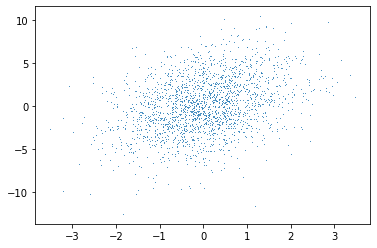

In [5]:
from  matplotlib  import pyplot as plt
plt.scatter(X[:, 0], Y[:, 1], lw=0.0, s=1.0)

In [6]:
X.shape, Y.shape

((2000, 9), (2000, 4))

Initialize the model. Note that we'll also initialize the "optimizer". Check out [this link](http://ruder.io/optimizing-gradient-descent/) to learn more about different optimizers. For now, `Adam` is a good choice.

In [7]:
model = Bottleneck(9, 4, 3)
o = optim.Adam(model.parameters())

In [8]:
o

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

In [9]:
model.lin1.bias

Parameter containing:
tensor([ 0.2466, -0.1579,  0.0878], requires_grad=True)

In [10]:
model.lin2.weight.data.shape

torch.Size([4, 3])

In [11]:
model.lin1.bias.data.shape

torch.Size([3])

In [12]:
model.lin1.bias.grad

In [13]:
from random import shuffle


def chunks(X, Y, size):
    """Yield successive `size` chunks from X & Y."""
    starts = list(range(0, len(X), size))
    shuffle(starts)
    for i in starts:
        yield (X[i:i + size], Y[i:i + size])

In [14]:
batch_size = 64
losses = []
for epoch in range(400):
    for itr, (feature, target) in enumerate(chunks(X, Y, batch_size)):
        # This zeros the gradients on every parameter. 
        # This is easy to miss and hard to troubleshoot.
        o.zero_grad()
        # Convert 
        feature = Variable(torch.from_numpy(feature))
        target = Variable(torch.from_numpy(target))
        # Compute a prediction for these features
        prediction = model.forward(feature)
        # Compute a loss given what the true target outcome was
        loss = model.loss(prediction, target)
        # break
        # Backpropagate: compute the direction / gradient every model parameter
        # defined in your __init__ should move in in order to minimize this loss
        # However, we're not actually changing these parameters, we're just storing
        # how they should change.

        loss.backward()
        # Now take a step & update the model parameters. The optimizer uses the gradient at 
        # defined on every parameter in our model and nudges it in that direction.
        o.step()
        # Record the loss per example
        losses.append(loss.data.numpy() / len(feature))
        if epoch % 10 == 0 and itr ==0:
            print(epoch, loss.data)


0 tensor(3016.2830)
10 tensor(2579.7898)
20 tensor(1478.3911)
30 tensor(859.4304)
40 tensor(978.7653)
50 tensor(639.4958)
60 tensor(498.6419)
70 tensor(736.4422)
80 tensor(518.9033)
90 tensor(620.0474)
100 tensor(451.3007)
110 tensor(467.2325)
120 tensor(585.6874)
130 tensor(587.3538)
140 tensor(455.5283)
150 tensor(466.4092)
160 tensor(450.3227)
170 tensor(576.0474)
180 tensor(97.5949)
190 tensor(438.9212)
200 tensor(485.5689)
210 tensor(450.0540)
220 tensor(533.7489)
230 tensor(609.9304)
240 tensor(524.7550)
250 tensor(466.8061)
260 tensor(515.9125)
270 tensor(467.4266)
280 tensor(559.1437)
290 tensor(559.2724)
300 tensor(674.1703)
310 tensor(527.8735)
320 tensor(376.3795)
330 tensor(466.6500)
340 tensor(559.5760)
350 tensor(437.3701)
360 tensor(519.8002)
370 tensor(450.5840)
380 tensor(488.7842)
390 tensor(362.1479)


In [15]:
batch_size

64

In [16]:
loss

tensor(430.0216, grad_fn=<AddBackward0>)

In [17]:
model.lin1.weight

Parameter containing:
tensor([[ 1.2162, -0.2459,  0.0810, -0.9829, -0.1567,  0.0116,  0.7987, -0.2269,
         -0.7186],
        [-0.1150,  0.0906,  0.2962,  0.5998, -0.9967,  0.1324, -0.8731, -0.5354,
         -1.5160],
        [ 0.6616,  0.5662,  1.4395, -0.3077,  0.0232, -0.3601, -0.1868,  0.0142,
          0.0868]], requires_grad=True)

In [18]:
o.step()

In [19]:
model.lin1.weight

Parameter containing:
tensor([[ 1.2162, -0.2457,  0.0809, -0.9831, -0.1563,  0.0119,  0.7986, -0.2267,
         -0.7187],
        [-0.1151,  0.0906,  0.2964,  0.5996, -0.9965,  0.1326, -0.8731, -0.5352,
         -1.5160],
        [ 0.6613,  0.5663,  1.4396, -0.3076,  0.0231, -0.3604, -0.1867,  0.0146,
          0.0871]], requires_grad=True)

In [20]:
model.lin1.weight.grad

tensor([[ 18.9516, -14.5587,  41.9709,  -8.1529, -27.1436, -26.0068,   4.5573,
         -16.5971, -23.0617],
        [ 15.6695, -32.3243,  -5.2294,   9.1798,  -5.7506,  -3.9608, -12.4963,
         -20.7301,   1.6327],
        [ 33.7974, -24.8127, -34.5951,   3.6815, -24.0357,  45.6322,  -2.6379,
         -11.7901, -72.5427]])

I can introspect my model and get the parameters out:

In [21]:
model.lin1.weight.data.numpy()

array([[ 1.216248  , -0.2457069 ,  0.08085664, -0.9830587 , -0.1563447 ,
         0.01190823,  0.7986346 , -0.22673753, -0.7187076 ],
       [-0.11509013,  0.09063391,  0.2963594 ,  0.5995957 , -0.9965461 ,
         0.13260062, -0.8731001 , -0.53518844, -1.516025  ],
       [ 0.6613134 ,  0.5663334 ,  1.4395748 , -0.30763304,  0.02307196,
        -0.36041868, -0.1867382 ,  0.01455708,  0.08706409]],
      dtype=float32)

In [22]:
model.lin1.bias.data.numpy()

array([ 0.05545653,  0.03912283, -0.0066179 ], dtype=float32)

I can also see that the loss is simply a scalar:

In [23]:
loss

tensor(430.0216, grad_fn=<AddBackward0>)

You can see that the gradient is zero before we call `loss.backward()`

In [24]:
model.lin1.bias.grad

tensor([  1.2084,  -2.4452, -44.4982])

...And non-zero afterwards.

In [25]:
model.lin1.bias.grad

tensor([  1.2084,  -2.4452, -44.4982])

In [26]:
model.lin1.bias.data

tensor([ 0.0555,  0.0391, -0.0066])

And after we run `o.step()` we'll notice that the bias parameter has been updated:

In [27]:
model.lin1.bias.data.numpy()

array([ 0.05545653,  0.03912283, -0.0066179 ], dtype=float32)

Let's check on convergence:

In [28]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

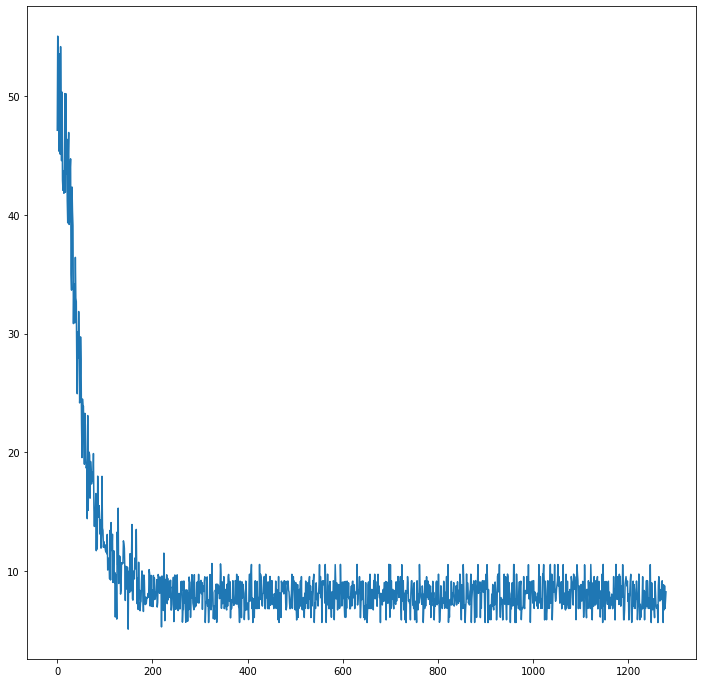

In [29]:
n = len(losses)
smooth = np.convolve(losses, np.ones((n,))/n, mode='valid')
plt.figure(figsize=(12, 12))
plt.plot(losses[::10])
plt.plot(smooth, c='r')

Looks converged to me!

### Exercise